In [1]:
import json
from collections import Counter
from typing import Optional, Dict
from pathlib import Path
import pysolr
from pydantic import BaseModel
from tqdm import tqdm

from data_loading import load_search_terms, TermType, load_tlc_samples
from models import SearchTerm
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
class Match(BaseModel):
    mention: SearchTerm
    match: Optional[Dict] = None
    matched_string: Optional[str] = None


solr_special_chars = '+ - && || ! ( ) { } [ ] ^ " ~ * ? : /'.split()

In [3]:
solr = pysolr.Solr('http://localhost:8983/solr/wumls-single-valued-deduplicated',
                   always_commit=False)
# solr = pysolr.Solr('http://localhost:8983/solr/wumls-multi-valued', always_commit=False)
solr.ping()

'{\n  "responseHeader":{\n    "zkConnected":null,\n    "status":0,\n    "QTime":1,\n    "params":{\n      "q":"{!lucene}*:*",\n      "distrib":"false",\n      "df":"_text_",\n      "rows":"10",\n      "echoParams":"all",\n      "rid":"localhost-90297"}},\n  "status":"OK"}\n'

In [4]:
def show_search_score_proportion(matches):
    nums_matched = []
    x = np.linspace(0,1,10)
    for threshold in x:
        num_matched = len([match for match in matches if match.match['score'] > threshold])
        nums_matched.append(num_matched/len(matches))
        
    fig,ax = plt.subplots()
    ax.plot(x, nums_matched )
    ax.set_xlabel("score threshold")
    ax.set_ylabel("% matched")
    ax.grid()
    plt.show()


In [5]:
distances = {True: 1, False: 2}


def add_tilde_to_search_terms(term):
    return " AND ".join([s + f"~{distances[len(s) < 4]}" for s in term.split(" ")])


def create_query_with_edit_distance(term):
    return "{!func}strdist('" + term + "',index_term,edit)"

In [6]:
results = solr.search(q=create_query_with_edit_distance(term="kolik"), fl="*,score")
for res in results:
    print(res)

{'cui': ['C0036572'], 'source': ['WIKTIONARY'], 'language': ['GER'], 'name': ['kolik'], 'index_term': ['kolik'], 'id': '432ca26d-2b92-4c55-9c93-2919c96c3cb3', '_version_': 1760194257032839174, 'score': 1.0}
{'cui': ['C0009319'], 'source': ['MDRGER'], 'language': ['GER'], 'name': ['Kolitis'], 'index_term': ['koliti'], 'id': 'c96f6f31-41d0-4efc-b016-49e9b9529fe7', '_version_': 1760194257369432091, 'score': 0.6666666}
{'cui': ['C0009319'], 'source': ['MDRGER'], 'language': ['GER'], 'name': ['Kolitis (NNB)'], 'index_term': ['koliti (nnb)'], 'id': 'e2a97d6a-d685-4ae7-8295-3904144202b7', '_version_': 1760194257369432093, 'score': 0.6666666}
{'cui': ['C0009319'], 'source': ['MDRGER'], 'language': ['GER'], 'name': ['Kolitis NNB'], 'index_term': ['koliti nnb'], 'id': 'c2983af1-19b2-41df-a45b-c3dba3b63c8a', '_version_': 1760194257369432094, 'score': 0.6666666}
{'cui': ['C0009324'], 'source': ['MDRGER'], 'language': ['GER'], 'name': ['Kolitis ulcerosa'], 'index_term': ['koliti ulcerosa'], 'id': '

In [7]:
search_term = "kolik (NBB)"
# results = solr.search(q=f"index_term_str:{add_tilde_to_search_terms(search_term)}", fl="*", rows=10)
results = solr.search(q=f"index_term:{search_term}", fl="*", rows=10)
for res in results:
    print(res)

{'cui': ['C0036572'], 'source': ['WIKTIONARY'], 'language': ['GER'], 'name': ['kolik'], 'index_term': ['kolik'], 'id': '432ca26d-2b92-4c55-9c93-2919c96c3cb3', '_version_': 1760194257032839174}
{'cui': ['C0151824'], 'source': ['MDRGER'], 'language': ['GER'], 'name': ['Kolik Galle'], 'index_term': ['kolik gall'], 'id': '7c20a889-4a3a-455e-ad0b-ee0b1bea9667', '_version_': 1760194258488262674}
{'cui': ['C0232488'], 'source': ['WHOGER'], 'language': ['GER'], 'name': ['KOLIK ABDOMINAL'], 'index_term': ['kolik abdominal'], 'id': 'b1ba2e8e-af5d-480a-bb80-2465c919aff3', '_version_': 1760194259123699714}
{'cui': ['C0232488'], 'source': ['MDRGER'], 'language': ['GER'], 'name': ['abdominale Kolik'], 'index_term': ['abdominal kolik'], 'id': '64219f63-93be-4b1c-a548-b0028e5b4c60', '_version_': 1760194259123699715}
{'cui': ['C0266836'], 'source': ['MDRGER'], 'language': ['GER'], 'name': ['infantile Kolik'], 'index_term': ['infantil kolik'], 'id': '605ee1d6-123a-4913-85fc-461a4f776b09', '_version_': 1

In [8]:
search_terms = load_search_terms()

In [ ]:
def filter_results_by_common_cuis(results):
    cuis = [d['cui'][0] for d in results]
    counter = Counter(cuis)
    most_common_match_cui = counter.most_common()[0][0]
    most_common_match = next(d for d in results if d['cui'][0] == most_common_match_cui)
    return most_common_match


matched, not_matched = [], []
for term in tqdm(search_terms.terms):
    # simple, not weighted majority vote for cui
    results = []
    for stem in term.stems:
        for char in solr_special_chars:
            stem = stem.replace(char, '\\' + char)
        try:
            res = solr.search(q=create_query_with_edit_distance(term=stem), fl="*,score", rows=1)
        except pysolr.SolrError:
            continue
        if not res:
            # print('no res found')
            continue
        # print('found res')
        top_result = list(res)[0]
        # if top_result['score'] < .5:
        #     continue
        top_result['stem'] = stem
        results.append(top_result)
    if results:
        most_common_match = filter_results_by_common_cuis(results=results)
        matched.append(Match(mention=term, match=most_common_match, matched_string=most_common_match['stem']))
    else:
        not_matched.append(Match(mention=term))

 82%|████████▏ | 6088/7390 [1:45:57<07:46,  2.79it/s]  

In [9]:
path = Path('matched.json')
if path.exists():
    print("path exists")
else:
    with open(path, 'w') as fp:
        json.dump([match.json() for match in matched], fp)

NameError: name 'matched' is not defined

In [ ]:
path = Path('not_matched.json')
if path.exists():
    print("path exists")
else:
    with open(path, 'w') as fp:
        json.dump([match.json() for match in not_matched], fp)

In [10]:
print(f"{len(matched)=}")
print(f"{len(not_matched)=}")


NameError: name 'matched' is not defined

In [11]:
path = Path('matched_strdist.json')
with open(path, 'r') as fp:
    matched_strdist = json.load(fp)
matched_strdist = [Match.parse_obj(json.loads(match)) for match in matched_strdist]

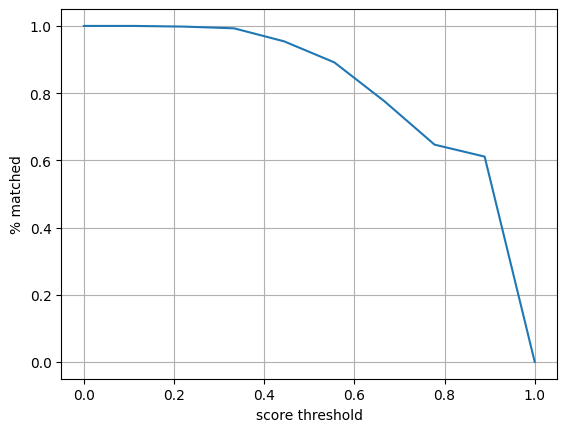

In [12]:
show_search_score_proportion(matched_strdist)

In [13]:
def print_n_matches(matches, n=10):
    for matched_item in random.sample(matches, n):
        annotation = matched_item.mention.annotation
        synonyms_from_tlc = matched_item.mention.stems
        original_mention = annotation.get_mention()
        matched_string = matched_item.matched_string if matched_item.matched_string else synonyms_from_tlc
        print(matched_string, " matched with ",matched_item.match['index_term'],
              f"(score = {matched_item.match['score']})")
        print()

print_n_matches(matched_strdist)

{'protei und gluko im uri', 'nephropathie'}  matched with  ['puumala virus-nephropathie'] (score = 1.0)

{'costa', 'ripp'}  matched with  ['ripp'] (score = 1.0)

{'hypotonu', 'zu niedrig blutdruck', 'niedrig blutdruck', 'hypotonie'}  matched with  ['hypotonu'] (score = 1.0)

{'intestinal mikrobiom', 'darmflora', 'intestinal mikrobiota', 'intestinalflora'}  matched with  ['darmflora'] (score = 1.0)

{'schrumpfnier', 'schrumpf 5cm nier', 'nephrozirrho', 'vernarbt nier'}  matched with  ['schrumpfnier'] (score = 1.0)

{'blinddarm -op', 'appendix', 'entfernung des wurmfortsatz', 'blinddarmentnahm', 'appendektomie', 'blinddarmentfernung', 'blinddarm-op'}  matched with  ['blinddarmentzundung'] (score = 0.78947365)

{'erbrech', 'vomitu', 'emesi'}  matched with  ['erbrech'] (score = 1.0)

{'kontrastmittel', 'km'}  matched with  ['kontrastmittel'] (score = 1.0)

{'stei in der nier', 'niernestei', 'gallenstei - syn. cholelith', 'konkrement', 'nierenstein, syn. nephrolith', 'steinch', 'nephrolithi

In [14]:
threshold = 0.69 # some false negatives with .7, so .69 seems to work good
cutoff_matches = [match for match in matched_strdist if match.match['score'] > threshold]
below_cutoff = [match for match in matched_strdist if match.match['score'] <= threshold]
print(len(cutoff_matches),'/', len(matched_strdist))
print_n_matches(cutoff_matches)

5352 / 7390
{'zystitid (pl. von zystitis)', 'nitrit, blut und leuko ist erhoh im uri', 'blasenreizung', 'weiss und rot blutkorperch sowie nitrit im uri', 'harnwegsinfekt', 'harnwegserkrankung', 'urozystitid', 'infekt der harmweg', 'nitrit, leucocyten, erythrocyt', 'harnwegsinfektio', 'balsenentzundung', 'blasenentzundung', 'harnwegsentzundung', 'zystitid', 'leuko und blu', '[normalerwei leukozyten, evtl. (aber nich zwingend) nitrit oder erythrozyt', 'blasenentzunung', 'blasenetzundung', 'blasentzundung', 'bes', 'im uri war vor einer woch noch blut und bakterie', 'urozystiti', 'blasenentzudung', 'leuko ohn end im uri', 'blasenentzuendung', 'entzu bla', 'zystiti', 'blaseninfekt', 'hwi'}  matched with  ['blasenentzundung'] (score = 0.9375)

{'kontrastdarstellung von nier und harnwegsyst', 'urographie'}  matched with  ['urographie'] (score = 1.0)

{'dickdarmtumor', 'kolonkarzinom', 'kolorektal karzinom', 'darmkreb'}  matched with  ['darmkreb nnb'] (score = 1.0)

{'raumforderung', 'tumor', 

In [15]:
print_n_matches(below_cutoff)

{'nierenfacharzt', 'nierenarzt', 'nephrolog', 'nephrolg', 'spezialist fur nierenerkrankung', 'nierenspezialist'}  matched with  ['niereninfarkt'] (score = 0.64285713)

{'kein wass lass', 'gar nich mehr wass lass kann', 'ischurie', 'kann nich pipi mach', 'harnverhalt'}  matched with  ['huma antichima antikoerper-test'] (score = 0.42105263)

{'md-gripp', 'mag darm infekt', '1 tag kotzerei und dann so 3-4 tag durchfall', 'norovirus-infektio', 'gastroenteritis, verursach vor allem durch noroviru', 'norovirus-gastroenteriti', 'mag darm gripp', 'mag darm infektio', 'mag darm viru', 'magen-darm-gripp', 'magendarmgripp', 'gastroenteriti', 'viral gastroenteriti', 'noroviru', 'magen-darm-viru', 'magen-darm-infekt'}  matched with  ['magengripp'] (score = 0.625)

{'nierenentzuendung', 'nierenbeckentzundung', 'nierenbeckenentzudung', 'nier entzundung', 'pyelonephritid', 'nierenbeckeninfektio', 'pyelonephriti', 'schmerz im nierenbereich', 'nierenbecken)infekt', 'nierenbeckenntzundung', 'nierenbecken

## Analyze not mached mentions

In [21]:
print(below_cutoff[0])


mention=SearchTerm(annotation=Annotation(tech_term='Nierenbeckenentzündung', lay_term=None, type=<TermType.TECH: 'TECH'>, span_start=30, span_end=52, synonyms=['Pyelonephritis'], id=3633), stems={'nierenentzuendung', 'nierenbeckentzundung', 'nierenbeckenentzudung', 'nier entzundung', 'pyelonephritid', 'nierenbeckeninfektio', 'pyelonephriti', 'schmerz im nierenbereich', 'nierenbecken)infekt', 'nierenbeckenntzundung', 'nierenbeckenentzudnung', 'schmerz in der flank /nierengeg', 'nephriti', 'nierenenzundung', 'entzundung in der nier', 'nephritid', 'nierenbeckenenztundung', 'schmerz im rucken/flankenbereich', 'nierenbeckenentundung', 'infektio der nier', 'entzudnung in nierenbereich', 'nierenbeckenentzundung', 'nierenbeckenzundung', 'nieren(becken)entzundung', 'nierenentzundung', 'nierenbeckenentzungung', 'hoh fieber, schuttelfrost, und schmerz'}) match={'cui': ['C0022667'], 'source': ['WHOGER'], 'language': ['GER'], 'name': ['NIERENPAPILLENENTZUENDUNG'], 'index_term': ['nierenpapillenentz

In [26]:
class SampleCollection:
    def __init__(self):
        self.samples = load_tlc_samples()
        self.id_mapping = {sample.id: sample for sample in self.samples}
        self.annotation_id_mapping = {annotation.id: sample for sample in self.samples for annotation in sample.annotations}
    
    def get_sample_by_id(self, identifier:int):
        return self.id_mapping[identifier]
    
    def get_sample_by_annotation_id(self, identifier:int):
        return self.annotation_id_mapping[identifier]

sample_collection = SampleCollection()

In [28]:
sample_collection.get_sample_by_annotation_id(below_cutoff[0].mention.annotation.id)


Sample(annotations=[Annotation(tech_term='Nierenbeckenentzündung', lay_term=None, type=<TermType.TECH: 'TECH'>, span_start=30, span_end=52, synonyms=['Pyelonephritis'], id=3633)], text='wenn du zu dem Facharzt gehst und sagst du hast Schmerzen dürfen!! sie dich nicht wegschicken ansonsten rede nochmal mit deiner Hausärztin das sie die praxis anruft und um einen früheren termin bittet', file_name='file_5145_wirdschoalles_2007-10-20_', subforum=<SubForumType.KIDNEY: 'KIDNEY'>, id=1575)

In [29]:
from termcolor import colored

In [31]:
for sample in 
colored("hallo", "red")

hallo


In [34]:
for search_term in below_cutoff:
    annotation = search_term.mention.annotation
    sample = sample_collection.get_sample_by_annotation_id(annotation.id)
    text = sample.text
    colored_mention = colored(text[annotation.span_start:annotation.span_end], "red")
    text_with_colors = text[:annotation.span_start] + colored_mention + text[annotation.span_end:]
    print(text_with_colors)
    break

wenn du zu dem Facharzt gehst und sagst du hast Schmerzen dürfen!! sie dich nicht wegschicken ansonsten rede nochmal mit deiner Hausärztin das sie die praxis anruft und um einen früheren termin bittet
